# STDP spiking classifier for somatosensory data

Increasing width of notebook, (not important, just preference)

In [38]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:75% !important; }</style>"))

## brian2 installation!

In [3]:
!python -m pip install brian2
!python -m pip install brian2tools

## Import statements

In [72]:
import numpy as np
import matplotlib.cm as cmap
import time
import os.path
import scipy 
import pickle
import brian2 as b
from struct import unpack
from brian2 import *
from brian2tools import *
from IPython.display import clear_output

In [311]:
# testing cell
# i_arr = np.array([0,1,1])
# print(i_arr==1)
# arr = np.array([[1,2,3],[4,5,6]])
# print(arr[[True, False]])
# print(arr[i_arr==1])
np.array([[1],[1],[1]]).flatten()
#rate = np.sum(result_monitor[np_input_labels == j,:], axis = 0) / num_assignments

array([1, 1, 1])

## Functions

In [334]:
### Functions to load data

def get_labeled_touch_vec_data(first_file_num, last_file_num, data_path):
    
    N = last_file_num - (first_file_num - 1)
    tot_N = N * 26
    x = np.zeros((tot_N, 5))
    y = np.zeros((tot_N, 1))
    
    pos = 0
    for file_num in range(first_file_num, last_file_num+1):
        file_name = 'Training' + str(file_num) + '.txt'
        file_path = data_path + file_name
        touch_vecs = open(file_path)
        for letter in range(26):
            y[letter + pos] = (ord(touch_vecs.read(1)) - 65)
            
            touch_vecs.read(1)
        x[pos:(pos+26), :] = np.transpose(np.loadtxt(file_path, skiprows=1))
        
        pos += 26
    
    data = {'data': x, 'labels': y}
    return data



### Runtime functions

# result_monitor contains [since_last_update, spike_count_for_sample_per_neuron]
# input_labels contains [label_for_last_26_samples]
def get_new_assignments(result_monitor, input_labels):
    assignments = np.zeros(n_e)
    print(input_labels)
    np_input_labels = np.asarray(input_labels)
    maximum_rate = [0] * n_e
    for j in range(26):
        num_assignments = len(np.where(np_input_labels == j)[0]) #selects the samples with label j
        if num_assignments > 0:
            print('np_input_labels  shape ' + str(np_input_labels.shape))
            print('result_monitor shape ' + str(result_monitor.shape))
            relevant_sample_results = result_monitor[np_input_labels == j]
            rate = np.sum(relevant_sample_results, axis = 0) / num_assignments #takes the avg response of
                                                                                    # each neuron during the samples 
                                                                                    # with label j
        for i in range(n_e):
            if rate[i] > maximum_rate[i]:
                maximum_rate[i] = rate[i]
                assignments[i] = j
    return assignments


### All this probably won't work because the input_dim is not a square value, oh well figure that out later
def get_2d_input_weights():
    weight_matrix = np.zeros((input_dim, n_e))
    n_e_sqrt = int(np.sqrt(n_e))
    n_in_sqrt = int(np.sqrt(input_dim))
    num_values_col = n_e_sqrt*n_in_sqrt
    num_values_row = num_values_col
    rearranged_weights = np.zeros((num_values_col, num_values_row))
    connMatrix = np.zeros((input_dim, n_e))
    connMatrix[input_synapses.i, input_synapses.j] = input_synapses.w
    weight_matrix = np.copy(connMatrix)

    for i in range(n_e_sqrt):
        for j in range(n_e_sqrt):
                rearranged_weights[i*n_in_sqrt : (i+1)*n_in_sqrt, j*n_in_sqrt : (j+1)*n_in_sqrt] = \
                    weight_matrix[:, i + j*n_e_sqrt].reshape((n_in_sqrt, n_in_sqrt))
    return rearranged_weights


def normalize_input_weights():
    len_source = len(input_synapses.source)
    len_target = len(input_synapses.target)
    synapse_weights = np.zeros((len_source, len_target))
    synapse_weights[input_synapses.i, input_synapses.j] = input_synapses.w
    temp_conn = np.copy(synapse_weights)
    colSums = np.sum(temp_conn, axis = 0)
    colFactors = weight['ee_input']/colSums
    for j in range(n_e):#
        temp_conn[:,j] *= colFactors[j]
    input_synapses.w = temp_conn[input_synapses.i, input_synapses.j]
                    

# This function grabs the label for which neurons with that label have the highest activity on average
# spike_rates contains [spike_count_for_sample_per_neuron]
def get_recognized_number_ranking(assignments, spike_rates):
    summed_rates = [0] * 26
    num_assignments = [0] * 26
    for i in range(26):
        num_assignments[i] = len(np.where(assignments == i)[0])
        if num_assignments[i] > 0:
            summed_rates[i] = np.sum(spike_rates[assignments == i]) / num_assignments[i]
        
    return np.argsort(summed_rates)[::-1]



### Plotting fuctions

def plot_performance(fig_num):
    num_evaluations = int(sample_count/update_interval)
    time_steps = range(0, num_evaluations)
    performance = np.zeros(num_evaluations)
    fig = figure(fig_num, figsize = (5, 5))
    #fig_num += 1
    ax = fig.add_subplot(111)
    im2, = ax.plot(time_steps, performance) #zxzhijia's 
    ylim(ymax = 100)
    title('Classification performance')
    plt.show()
    return im2, performance, fig_num, fig


def update_performance_plot(im, performance, current_example_num, fig):
    num_evaluations = int(sample_count/update_interval)
    time_steps = range(0, num_evaluations)
    performance = get_current_performance(performance, current_example_num)
    fig = figure(fig_num, figsize = (5, 5))
    #fig_num += 1
    print(fig_num)
    ax = fig.add_subplot(111)
    im2, = ax.plot(time_steps, performance) #zxzhijia's 
    ylim(ymax = 100)
    title('Classification performance')
    plt.show()
    return im, performance


def get_current_performance(performance, current_example_num):
    current_evaluation = int(current_example_num/update_interval)
    start_num = current_example_num - update_interval
    end_num = current_example_num
    difference = outputNumbers[start_num:end_num, 0] - input_labels[start_num:end_num]
    correct = len(np.where(difference == 0)[0])
    performance[current_evaluation] = correct / float(update_interval) * 100
    return performance


def plot_2d_input_weights(fig_num):
    weights = get_2d_input_weights()
    fig = plt.figure(fig_num, figsize = (18, 18))
    im2 = plt.imshow(weights, interpolation = "nearest", vmin = 0, vmax = wmax_ee, cmap = cmap.get_cmap('hot_r'))
    plt.colorbar(im2)
    plt.title('weights of input connection')
    fig.canvas.draw()
    return (fig_num + 1), im2, fig


def update_2d_input_weights(im, fig):
    weights = get_2d_input_weights()
    im.set_array(weights)
    fig.canvas.draw()
    return im


## Loading data into np arrays

In [335]:
# specify the location of the data
notebook_path = os.path.abspath("BRIAN_DIEHL_COOK_2015.ipynb")

touch_data_vec_path = os.path.join(os.path.dirname(notebook_path), "Datasets\\Vector-data-of-A-Z\\")

start = time.time()
training = get_labeled_touch_vec_data(1,19,touch_data_vec_path)
end = time.time()
#print('time needed to load training set:', end - start)
 
start = time.time()
testing = get_labeled_touch_vec_data(20,20,touch_data_vec_path)
end = time.time()
#print('time needed to load test set:', end - start)


In [330]:
training['labels'][[53,55]] = training['labels'][[55,53]]


In [336]:
training['labels']

array([[ 0.],
       [ 1.],
       [ 2.],
       [ 3.],
       [ 4.],
       [ 5.],
       [ 6.],
       [ 7.],
       [ 8.],
       [ 9.],
       [10.],
       [11.],
       [12.],
       [13.],
       [14.],
       [15.],
       [16.],
       [17.],
       [18.],
       [19.],
       [20.],
       [21.],
       [22.],
       [23.],
       [24.],
       [25.],
       [ 0.],
       [ 1.],
       [ 2.],
       [ 3.],
       [ 4.],
       [ 5.],
       [ 6.],
       [ 7.],
       [ 8.],
       [ 9.],
       [10.],
       [11.],
       [12.],
       [13.],
       [14.],
       [15.],
       [16.],
       [17.],
       [18.],
       [19.],
       [20.],
       [21.],
       [22.],
       [23.],
       [24.],
       [25.],
       [ 0.],
       [ 1.],
       [ 2.],
       [ 3.],
       [ 4.],
       [ 5.],
       [ 6.],
       [ 7.],
       [ 8.],
       [ 9.],
       [10.],
       [11.],
       [12.],
       [13.],
       [14.],
       [15.],
       [16.],
       [17.],
       [18.],
      

## Setting parameters and equations for neuronal behaviour

In [337]:
# For using numpy directly for simulation instead of C++ codegen
prefs.codegen.target = 'numpy'

input_dim = 5
epoch_num = 100 #100 chosen to be in a similar order of magnitude as the number of training samples used in [1] (3 epochs (passes) of 60000 sized MNIST data)
epoch_sample_count = (26*19)
sample_count = (26 * 19) * epoch_num #(26 letters per trial, 19 trials)
n_e = 400 # excitatory neuron count in [1]: 400
n_i = n_e
input_sample_time = 350*ms
inter_input_time = 150*ms
full_sample_time = (input_sample_time + inter_input_time)
full_runtime = sample_time * sample_count


# These values just taken from [1]
v_rest_e = -65. * mV 
v_rest_i = -60. * mV 
v_reset_e = -65. * mV
v_reset_i = -45. * mV
v_thresh_e = -52. * mV
v_thresh_i = -40. * mV
refrac_e = 5. * ms
refrac_i = 2. * ms


update_interval = 26 # How often the assignments are updated
weight_update_interval = 26 # how often the plotted weights are updated, just uninteresting plot variable


weight = {}
delay = {}
weight['ee_input'] = 78. # Original function has this at 78, probably on the basis that there are 784 input neurons
                            # So by that logic it should be 0.5 for me for now, but let's just see how it goes w/ this
delay['ee_input'] = (0*ms,10*ms) 
delay['ei_input'] = (0*ms,5*ms) #This one isn't used currently

input_intensity = 64. # maximum Hz of input (gets increased if not generating enough output)
start_input_intensity = input_intensity # resets to this after each input, if it was increased


tc_pre_ee = 20*ms
tc_post_1_ee = 20*ms
tc_post_2_ee = 40*ms
nu_ee_pre =  0.0001      # Change in weight w/ learning
nu_ee_post = 0.01        # Change in weight w/ learning
wmax_ee = 1.0
exp_ee_pre = 0.2
exp_ee_post = exp_ee_pre
STDP_offset = 0.4 

## Reset stuff
theta_plus_e = 0.05 * mV
e_reset_str = 'v = v_reset_e; theta += theta_plus_e; timer = 0*ms'
i_reset_str = 'v=v_reset_i'

## threshold voltages
offset = 20.*mV
e_thresh_str = '(v>(theta - offset + v_thresh_e )) and (timer>refrac_e)' # I don't recall the raison d'etre of offset in the architecture
i_thresh_str = 'v>v_thresh_i'


#Equations for processing neural layers
tc_theta = 1e7 * ms #time constant for theta
eqs_e = '''
        dv/dt = ((v_rest_e - v) + (I_synE+I_synI) / nS) / (100*ms)  : volt (unless refractory)
        I_synE = ge * nS *         -v                               : amp
        I_synI = gi * nS * (-100.*mV-v)                             : amp
        dge/dt = -ge/(1.0*ms)                                       : 1
        dgi/dt = -gi/(2.0*ms)                                       : 1
        dtheta/dt = -theta / (tc_theta)  : volt
        dtimer/dt = 0.1  : second
        '''

eqs_i = '''
        dv/dt = ((v_rest_i - v) + (I_synE+I_synI) / nS) / (10*ms)  : volt (unless refractory)
        I_synE = ge * nS *         -v                              : amp
        I_synI = gi * nS * (-85.*mV-v)                             : amp
        dge/dt = -ge/(1.0*ms)                                      : 1
        dgi/dt = -gi/(2.0*ms)                                      : 1
        '''


#For excitatory to excitatory connection, in this case from input to excitatory neurons
eqs_stdp_ee = '''
                post2before                            : 1
                dpre/dt   =  -pre/(tc_pre_ee)         : 1 (event-driven)
                dpost1/dt  = -post1/(tc_post_1_ee)     : 1 (event-driven)
                dpost2/dt  = -post2/(tc_post_2_ee)     : 1 (event-driven)
            '''
eqs_stdp_pre_ee = 'pre = 1.; w = clip(w + nu_ee_pre * post1, 0, wmax_ee)'
eqs_stdp_post_ee = 'post2before = post2; w = clip(w + nu_ee_post * pre * post2before, 0, wmax_ee); post1 = 1.; post2 = 1.'



plt.ion() # Interactive mode on
fig_num = 1 # this might be causing issues in plotting
result_monitor = np.zeros((update_interval,n_e))



## Creation of network objects

In [338]:
#Create neuron groups
e_neurons = NeuronGroup(n_e, eqs_e, threshold= e_thresh_str, refractory= refrac_e, reset= e_reset_str, method='euler')
i_neurons = NeuronGroup(n_i, eqs_i, threshold= i_thresh_str, refractory= refrac_i, reset= i_reset_str, method='euler')

#set start voltages
e_neurons.v = v_rest_e - 40*mV
i_neurons.v = v_rest_e - 40*mV

#set theta values
e_neurons.theta = np.ones((n_e)) * 20.*mV

## Create connections between the excitatory and inhibitory neurons
# First excitatory to inhibitory synapses
e_weightMatrix = np.random.rand(n_e, n_i)
model = 'w : 1'
pre = 'ge_post += w'
post = ''

ei_synapses = Synapses(e_neurons, i_neurons, model=model, on_pre=pre, on_post=post)
ei_synapses.connect(True) #Creates all-to-all connection
ei_synapses.w = e_weightMatrix[ei_synapses.i, ei_synapses.j] #.i and .j refer to the pre and post neuron in the synapse


# inhibitory to excitatory synapses
pre = 'gi_post += w'
i_weightMatrix = np.random.rand(n_e, n_i)

ie_synapses = Synapses(i_neurons, e_neurons, model=model, on_pre=pre, on_post=post)
ie_synapses.connect(True) #Creates all-to-all connection
ie_synapses.w = i_weightMatrix[ei_synapses.i, ei_synapses.j] #.i and .j refer to the pre and post neuron in the synapse


### The creation of Poisson inputs from vec data
input_weightMatrix = np.random.rand(input_dim, n_e) #initially random weights
input_neurons = PoissonGroup(5, 0*Hz)


# creation of synapse from input to excitatory
model = 'w : 1' + eqs_stdp_ee
pre = 'ge_post += w; ' + eqs_stdp_pre_ee
post = eqs_stdp_post_ee

input_synapses = Synapses(input_neurons, e_neurons, model=model, on_pre=pre, on_post=post)

min_delay = delay['ee_input'][0]
max_delay = delay['ee_input'][1]
delta_delay = max_delay - min_delay
# TODO: test this ## That was note from brian2 translator, I wonder why, hmm

input_synapses.connect(True) # all-to-all connection
input_synapses.delay = 'min_delay + rand() * delta_delay'
input_synapses.w = input_weightMatrix[input_synapses.i, input_synapses.j]


### Creation of monitors
e_rate_monitor = PopulationRateMonitor(e_neurons)
i_rate_monitor = PopulationRateMonitor(i_neurons)
input_rate_monitor = PopulationRateMonitor(input_neurons)
rate_monitors = [e_rate_monitor, i_rate_monitor, input_rate_monitor]

e_spike_monitor = SpikeMonitor(e_neurons)
i_spike_monitor = SpikeMonitor(i_neurons)
spike_monitors = [e_spike_monitor, i_spike_monitor]

## Running the simulation

1


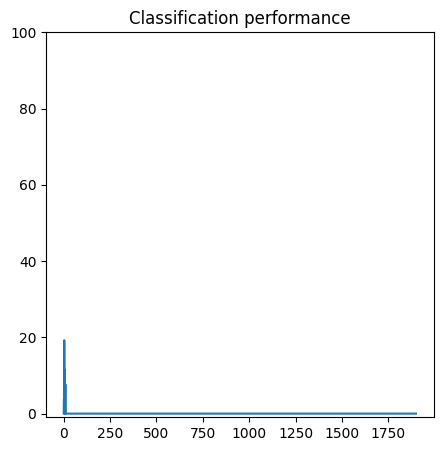

runs done: 234 of 49400
Classification performance  [ 0.          3.84615385  3.84615385 19.23076923  7.69230769 11.53846154
  7.69230769  0.          0.          7.69230769]
Starting simulation at t=117.5 s for a duration of 0.35 s
0.35 s (100%) simulated in 1s
Starting simulation at t=118. s for a duration of 0.35 s
0.35 s (100%) simulated in 1s
Starting simulation at t=118.5 s for a duration of 0.35 s
0.35 s (100%) simulated in 1s
Starting simulation at t=119. s for a duration of 0.35 s
0.35 s (100%) simulated in 1s
Starting simulation at t=119.5 s for a duration of 0.35 s
0.35 s (100%) simulated in 1s
Starting simulation at t=120. s for a duration of 0.35 s
0.35 s (100%) simulated in 1s
Starting simulation at t=120.5 s for a duration of 0.35 s
0.35 s (100%) simulated in 1s
Starting simulation at t=121. s for a duration of 0.35 s
0.35 s (100%) simulated in < 1s
Starting simulation at t=121.5 s for a duration of 0.35 s
0.35 s (100%) simulated in 1s
Starting simulation at t=122. s for

KeyboardInterrupt: 

In [339]:
previous_spike_count = np.zeros(n_e)
assignments = np.zeros(n_e)
input_labels = [0] * sample_count # not exactly certain what this one refers to
outputNumbers = np.zeros((sample_count, 26))
performance_monitor, performance, fig_num, fig_performance = plot_performance(fig_num)

for j in range(sample_count):
    #if j%150 == 0:
    #    clear_output()
    
    spike_rates = training['data'][j%(19*26),:] *  input_intensity
    input_neurons.rates = spike_rates * Hz
    
    normalize_input_weights()
    run(input_sample_time, report = 'text')
    #print("")
    
    if j % update_interval == 0 and j > 0:
        assignments = get_new_assignments(result_monitor[:], input_labels[j-update_interval : j])
    

    current_spike_count = np.asarray(e_spike_monitor.count[:]) - previous_spike_count
    previous_spike_count = np.copy(e_spike_monitor.count[:])
    if np.sum(current_spike_count) < 5:
        input_intensity += 1
        input_neurons.rates = 0 * Hz
        run(inter_input_time)
    else:
        result_monitor[j%update_interval,:] = current_spike_count
        input_labels[j] = training['labels'][j%epoch_sample_count][0]
        outputNumbers[j,:] = get_recognized_number_ranking(assignments, result_monitor[j%update_interval,:])
        #if j % 100 == 0 and j > 0:
        #    print('runs done:', j, 'of', int(sample_count))
            
        ####
        if j % update_interval == 0 and j > 0:
            clear_output()
            unused, performance = update_performance_plot(performance_monitor, performance, j, fig_performance)
            print('runs done:', j, 'of', int(sample_count))
            print('Classification performance ', performance[:int((j/float(update_interval))+1)])
            
        ####
        
        input_neurons.rates = 0 * Hz
        run(inter_input_time)
        input_intensity = start_input_intensity
        j += 1
    
# Unimportant plotting (a lot more where that came from)
# fig_num, input_weight_fig, fig_weights = plot_2d_input_weights(fig_num)
#     if j % weight_update_interval == 0:
#         update_2d_input_weights(input_weight_monitor, fig_weights)

# this thing is in the original code before the loop, no idea why 
# for i,name in enumerate(input_population_names):
#     input_groups[name+'e'].rates = 0 * Hz
# net.run(0*seb_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



In [ ]:
# plotting stuff
figure(fig_num)
fig_num += 1
for i, name in enumerate(rate_monitors):
    subplot(len(rate_monitors), 1, 1+i)
    plot(rate_monitors[name].t/b2.second, rate_monitors[name].rate, '.')
    title('Rates of population ' + name)

figure(fig_num)
fig_num += 1
for i, name in enumerate(spike_monitors):
    subplot(len(spike_monitors), 1, 1+i)
    plot(spike_monitors[name].t/b2.ms, spike_monitors[name].i, '.')
    title('Spikes of population ' + name)

if spike_counters:
    b2.figure(fig_num)
    fig_num += 1
    b2.plot(e_spike_monitor.count[:])
    b2.title('Spike count of excitatory population')




# example spiking for one input
# brian_plot(input_monitor).set_title('poisson input example spikes');

address these questions:

- Raison d'etre of offset in the architecture
- STDP_offset does what exactly
- check what exactly True means as a parameter in ```Synapses().connect(True)```
- is the fig_num parameter doing anything
- What exactly does get_new_assignments() do, or rather how, as what is kinda in the name
- Same for get_recognized_number_ranking()






Random thoughts:
- Connect multiple modalities of inputs to each other. That sounds really good and something that can be done pretty soon after I get this done